In [1]:
import numpy as np
import pandas as pd

In [2]:
products=pd.read_csv('amazon_baby.csv')
print products.shape
products.head()

(183531, 3)


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [3]:
products['review']=products['review'].astype(str)

In [4]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [5]:
products.head()

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [6]:
products = products[products['rating'] != 3]

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [8]:
print products.shape
products.head()

(166752, 5)


,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [9]:
train=pd.read_json('https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/indices-json/module-9-assignment-train-idx.json')
train_idx=[]
for i in train[0]:
    train_idx.append(i)

In [10]:
test=pd.read_json('https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/indices-json/module-9-assignment-test-idx.json')
test_idx=[]
for i in test[0]:
    test_idx.append(i)

In [11]:
train_data = products.iloc[train_idx]
test_data = products.iloc[test_idx]

In [12]:
print train_data.shape
print test_data.shape

(133416, 5)
(33336, 5)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [14]:
train_data.describe()

,rating,sentiment
count,133416.000000,133416.000000
mean,4.231486,0.681418
std,1.296922,0.731898
min,1.000000,-1.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logreg=LogisticRegression()
logreg.fit(train_matrix,train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy = accuracy_score(y_true=np.array(test_data['sentiment']), y_pred=logreg.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932445404368


In [21]:
baseline = len(test_data[test_data['sentiment'] == 1])/float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [22]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=np.array(test_data['sentiment']),
                        y_pred=logreg.predict(test_matrix),
                        labels=logreg.classes_)

In [23]:
logreg.classes_

array([-1,  1], dtype=int64)

In [24]:
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(logreg.classes_):
    for j, predicted_label in enumerate(logreg.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3799
     -1       |        1        |  1442
      1       |       -1        |   810
      1       |        1        | 27285


In [25]:
false_positive=1442
false_negative=810

In [26]:
cost=false_positive*100+false_negative*1

In [27]:
cost

145010

In [29]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=np.array(test_data['sentiment']), 
                            y_pred=logreg.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949803320918


In [30]:
false_positives=1-precision

In [31]:
false_positives

0.050196679082396334

In [32]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=np.array(test_data['sentiment']),
                      y_pred=logreg.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971169247197


In [54]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    probabilities=pd.Series(probabilities)#convery numpy array to pandas series
    return(probabilities.apply(lambda prby: +1 if prby >= threshold else -1))  

In [98]:
probabilities=logreg.decision_function(test_matrix)
probabilities=1/(1+np.exp(probabilities))

In [99]:
probabilities

array([  2.18454435e-01,   7.47906479e-07,   6.89855414e-02, ...,
         5.21831106e-06,   2.36792856e-06,   1.83058802e-02])

In [100]:
print probabilities.shape
print test_matrix.shape

(33336L,)
(33336, 121713)


In [101]:
prediction=apply_threshold(probabilities,0.9)

In [86]:
positive_prediction=(prediction==1).sum()

In [87]:
positive_prediction

2674

In [88]:
y_pred=logreg.predict(test_matrix)

In [89]:
y_pred[y_pred==1].sum()

28727

In [90]:
true_positive=(test_data['sentiment']==1).sum()

In [68]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [105]:
precision_all=[]
for i in threshold_values:
    prediction=apply_threshold(probabilities,i)
    positive_prediction=(prediction==1).sum()
    precision_=float(true_positive)/positive_prediction
    precision_all.append(precision_)

In [107]:
precision_all=[]
for i in threshold_values:
    prediction=apply_threshold(probabilities,i)
    precision_=precision_score(np.array(test_data['sentiment']), np.array(prediction))
    precision_all.append(precision_)

C:\Users\Shaurya\Anaconda\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [108]:
precision_all

[0.1757431113039705,
 0.17503273679615888,
 0.17274725274725275,
 0.17173721340388007,
 0.17028343666961912,
 0.16877918612408271,
 0.16711349419124219,
 0.1643002028397566,
 0.1627379873073436,
 0.16176805650489862,
 0.16109839816933638,
 0.15906998158379373,
 0.15804066543438078,
 0.15704012990025515,
 0.15651162790697676,
 0.15549848237216904,
 0.15462224307836697,
 0.15306603773584906,
 0.15198290192353361,
 0.15011933174224343,
 0.14844124700239808,
 0.14780100937274693,
 0.14644755920734653,
 0.14615197863559115,
 0.14439286586855607,
 0.14383897889052527,
 0.14299827117806865,
 0.14225422045680239,
 0.14175386148480318,
 0.1401705115346038,
 0.139874213836478,
 0.13865652724968314,
 0.13826530612244897,
 0.13758647194465795,
 0.1372750642673522,
 0.13668133574941754,
 0.13560645497136908,
 0.13492271417343463,
 0.13342105263157894,
 0.13229056203605513,
 0.13169821380965077,
 0.13025998391852051,
 0.1292847503373819,
 0.12710941752857921,
 0.12602515035538545,
 0.124896836313617

In [109]:
recall_all=[]
for i in threshold_values:
    prediction=apply_threshold(probabilities,i)
    recall_ = recall_score(np.array(test_data['sentiment']),np.array(prediction))
    recall_all.append(recall_)

In [110]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

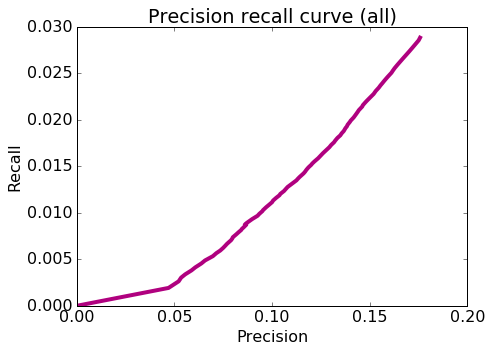

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')